# 🔍 Hyperparameter Tuning: Grid Search vs Random Search vs Bayesian Optimization
Using the Telco Customer Churn Dataset

## Step 1: Load and Inspect the Dataset

**What it does:** This step loads the Telco Customer Churn dataset into a Pandas DataFrame (`df`) and displays the first few rows using `df.head()`.
**Why it's important:**  It allows us to understand the structure and contents of the data before proceeding with analysis.

In [1]:

import pandas as pd

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2: Preprocessing

**What it does:** Prepares the data for machine learning by:
  * Removing irrelevant columns (customerID).
  * Converting data types (TotalCharges to numeric).
  * Handling missing values (dropping rows with missing data).
  * Encoding categorical features (using one-hot encoding).
  * Encoding the target variable ('Churn') to numerical values (0 and 1).
**Why it's important:** Data preprocessing ensures that the data is in a suitable format for machine learning algorithms to work effectively.

In [2]:

# Drop ID column, convert TotalCharges, handle missing
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
X = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
y = df['Churn']


## Step 3: Train-Test Split

**What it does:** Divides the dataset into training and testing sets.
**Why it's important:** This ensures that we have a separate dataset to evaluate the performance of our trained model on unseen data, preventing overfitting.

In [3]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


## Step 4: Grid Search

**What it does:** Systematically explores a predefined set of hyperparameters for a RandomForestClassifier using GridSearchCV.
**Why it's important:** Grid search helps us find the optimal combination of hyperparameters that yields the best model performance, measured by ROC AUC score.

In [4]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import time

param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [2, 5]}
grid_model = RandomForestClassifier(random_state=42)
start = time.time()
grid_cv = GridSearchCV(grid_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_cv.fit(X_train, y_train)
grid_time = time.time() - start
best_grid = grid_cv.best_estimator_
roc_auc_grid = roc_auc_score(y_test, best_grid.predict_proba(X_test)[:, 1])
grid_cv.best_params_, roc_auc_grid, grid_time


({'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100},
 np.float64(0.8346572856503361),
 39.75951528549194)

## Step 5: Random Search

**What it does:** Randomly samples hyperparameters within specified ranges using RandomizedSearchCV.
**Why it's important:** Random search can be more efficient than grid search, especially when exploring a large hyperparameter space. It also allows for greater flexibility in defining the search space.

In [5]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'n_estimators': randint(50, 150), 'max_depth': randint(3, 20), 'min_samples_split': randint(2, 10)}
random_model = RandomForestClassifier(random_state=42)
start = time.time()
random_cv = RandomizedSearchCV(random_model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
random_cv.fit(X_train, y_train)
random_time = time.time() - start
best_random = random_cv.best_estimator_
roc_auc_random = roc_auc_score(y_test, best_random.predict_proba(X_test)[:, 1])
random_cv.best_params_, roc_auc_random, random_time


({'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 113},
 np.float64(0.8375658380025524),
 36.76907515525818)

## Step 6: Bayesian Optimization

**What it does:** Uses Bayesian optimization (with Optuna) to intelligently search for the best hyperparameters.
**Why it's important:** Bayesian optimization can be even more efficient than random search by using previous evaluations to guide the search process, potentially finding better solutions with fewer iterations.

In [7]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 5.9 MB/s eta 0:00:00


In [8]:

import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 150),
        max_depth=trial.suggest_int('max_depth', 3, 20),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        random_state=42
    )
    return cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
bayes_time = time.time() - start
best_bayes = RandomForestClassifier(**study.best_params, random_state=42)
best_bayes.fit(X_train, y_train)
roc_auc_bayes = roc_auc_score(y_test, best_bayes.predict_proba(X_test)[:, 1])
study.best_params, roc_auc_bayes, bayes_time


[I 2025-03-27 11:05:07,683] A new study created in memory with name: no-name-a3b1451a-cefd-41c1-84e7-d1f6917552eb
[I 2025-03-27 11:05:13,018] Trial 0 finished with value: 0.8416162238588554 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8}. Best is trial 0 with value: 0.8416162238588554.
[I 2025-03-27 11:05:18,056] Trial 1 finished with value: 0.8434727815901872 and parameters: {'n_estimators': 89, 'max_depth': 11, 'min_samples_split': 7}. Best is trial 1 with value: 0.8434727815901872.
[I 2025-03-27 11:05:22,714] Trial 2 finished with value: 0.841864447413234 and parameters: {'n_estimators': 57, 'max_depth': 12, 'min_samples_split': 6}. Best is trial 1 with value: 0.8434727815901872.
[I 2025-03-27 11:05:27,345] Trial 3 finished with value: 0.8315730137763682 and parameters: {'n_estimators': 81, 'max_depth': 16, 'min_samples_split': 3}. Best is trial 1 with value: 0.8434727815901872.
[I 2025-03-27 11:05:35,785] Trial 4 finished with value: 0.841279398451213

({'n_estimators': 116, 'max_depth': 7, 'min_samples_split': 10},
 np.float64(0.8384243068669454),
 64.96965479850769)

## Step 7: ROC Curve Comparison

**What it does:** Visually compares the performance of the models trained using grid search, random search, and Bayesian optimization by plotting their ROC curves and calculating AUC scores.
**Why it's important:**  ROC curves and AUC scores provide a comprehensive evaluation of a classification model's ability to distinguish between classes.

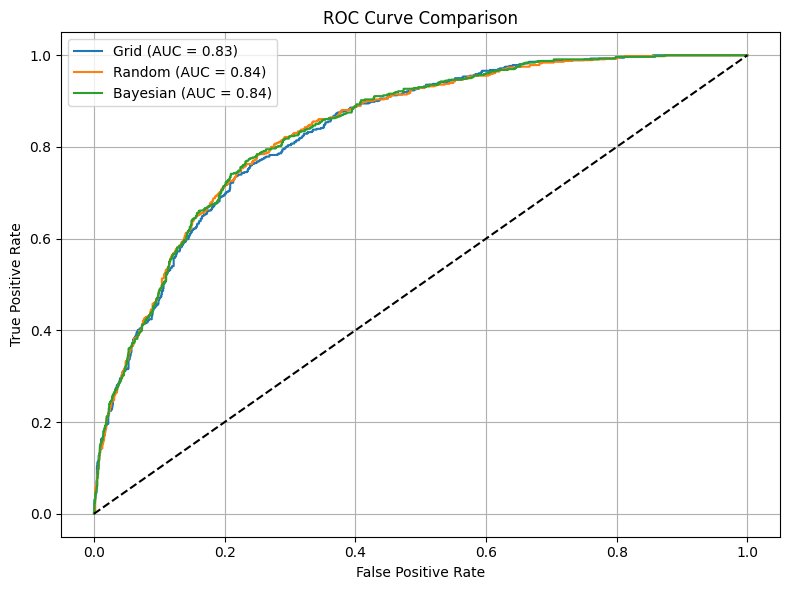

In [9]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities
y_proba_grid = best_grid.predict_proba(X_test)[:, 1]
y_proba_random = best_random.predict_proba(X_test)[:, 1]
y_proba_bayes = best_bayes.predict_proba(X_test)[:, 1]

# Compute ROC
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_proba_grid)
fpr_random, tpr_random, _ = roc_curve(y_test, y_proba_random)
fpr_bayes, tpr_bayes, _ = roc_curve(y_test, y_proba_bayes)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_grid, tpr_grid, label=f'Grid (AUC = {auc(fpr_grid, tpr_grid):.2f})')
plt.plot(fpr_random, tpr_random, label=f'Random (AUC = {auc(fpr_random, tpr_random):.2f})')
plt.plot(fpr_bayes, tpr_bayes, label=f'Bayesian (AUC = {auc(fpr_bayes, tpr_bayes):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 8: Confusion Matrix Comparison

**What it does:** Creates confusion matrices for each model to visualize the number of true positives, true negatives, false positives, and false negatives.
**Why it's important:** Confusion matrices provide a detailed breakdown of a classification model's performance, highlighting its strengths and weaknesses in predicting different classes.

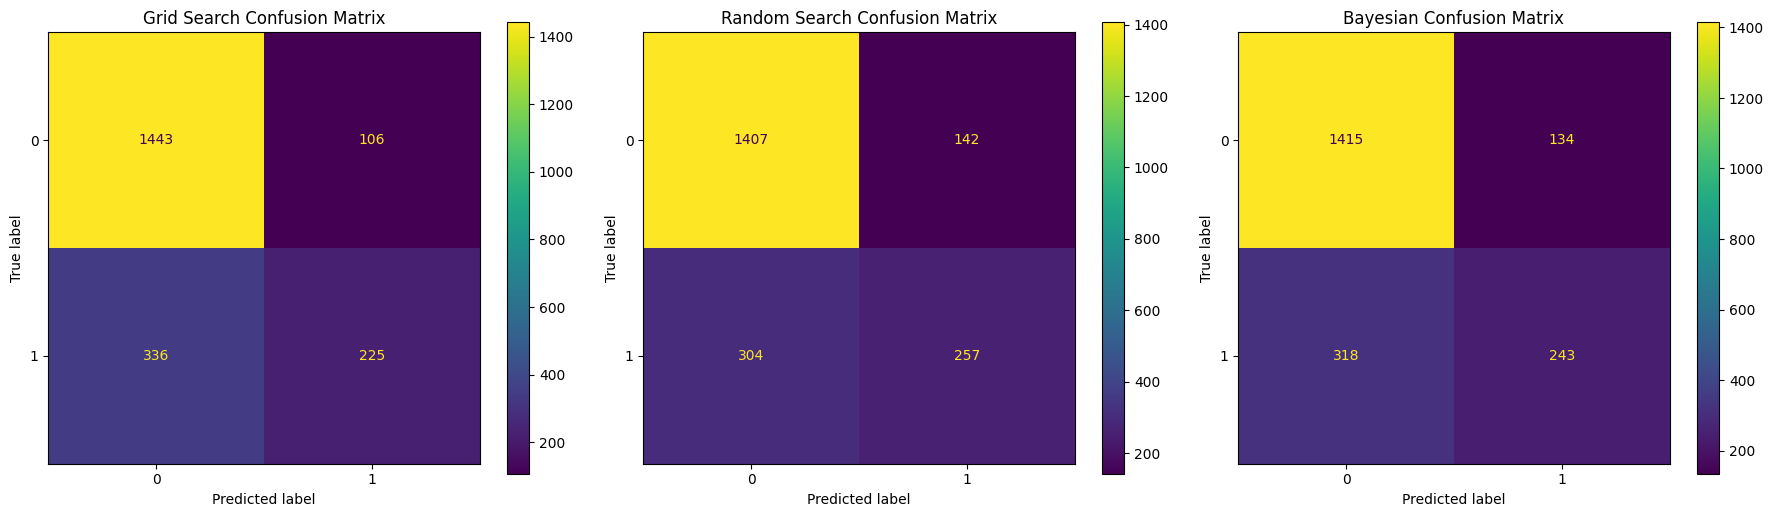

In [10]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [('Grid Search', best_grid), ('Random Search', best_random), ('Bayesian', best_bayes)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], values_format='d')
    axes[i].set_title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()
